`phylum (52 rows)`: phylum-level relative abundances per subject.

`genus (422 rows)`: genus-level relative abundances per subject.

`KO (2758 rows)`: KO functions (metaproteomic functional features) per subject.

`pathway (151 rows)`: KEGG pathways per subject.

`phylum+KO, genus+KO`: KO functions split by taxon (e.g. “K00001 in Bacillota”).

`phylum+pathway, genus+pathway`: pathways split by taxon (e.g. “Glycolysis in Faecalibacterium”)

In [3]:
import pandas as pd

# Load the main abundance table
data = pd.read_excel('../data/abundance_tables.xlsx', sheet_name=None)
# Check structure
for sheet_name, df in data.items():
    print(f"Sheet: {sheet_name}, Shape: {df.shape}")

Sheet: phylum, Shape: (52, 170)
Sheet: genus, Shape: (422, 170)
Sheet: KO, Shape: (2758, 172)
Sheet: pathway, Shape: (151, 171)
Sheet: phylum+KO, Shape: (6533, 172)
Sheet: genus+KO, Shape: (11557, 172)
Sheet: phylum+pathway, Shape: (1042, 171)
Sheet: genus+pathway, Shape: (4356, 171)


In [4]:
xls = pd.ExcelFile("../data/abundance_tables.xlsx")
phylum = pd.read_excel(xls, "phylum")
genus = pd.read_excel(xls, "genus")
ko = pd.read_excel(xls, "KO")

print(phylum.columns)
print(genus.columns[:10])
print(ko.columns[:10])

Index(['phylum', 'normalized abundance (no unassigned)', 'mean abundance',
       'mean cv', 'mean subjects', 'found in datasets', 'mean abundance D01',
       'mean abundance D02', 'mean abundance D03', 'mean abundance D04',
       ...
       'D09_S07', 'D09_S08', 'D09_S09', 'D09_S10', 'D10_S01', 'D10_S02',
       'D10_S03', 'D10_S04', 'D10_S05', 'D10_S06'],
      dtype='object', length=170)
Index(['genus', 'normalized abundance (no unassigned)', 'mean abundance',
       'mean cv', 'mean subjects', 'found in datasets', 'mean abundance D01',
       'mean abundance D02', 'mean abundance D03', 'mean abundance D04'],
      dtype='object')
Index(['KO', 'KO name', 'pathways', 'normalized abundance (no unassigned)',
       'mean abundance', 'mean cv', 'mean subjects', 'found in datasets',
       'mean abundance D01', 'mean abundance D02'],
      dtype='object')


In [5]:
meta_cols = [
    "genus",
    "normalized abundance (no unassigned)",
    "mean abundance",
    "mean cv",
    "mean subjects",
    "found in datasets",
]
meta_cols += [f"mean abundance D0{i}" for i in range(1, 10)] + ["mean abundance D10"]
meta_cols += [f"cv D0{i}" for i in range(1, 10)] + ["cv D10"]
meta_cols += [f"subjects D0{i}" for i in range(1, 10)] + ["subjects D10"]

sample_cols = [c for c in genus.columns if c not in meta_cols]

In [7]:
print(len(sample_cols))  # should be 134
sample_cols[:10]

134


['D01_S01',
 'D01_S02',
 'D01_S03',
 'D01_S04',
 'D01_S05',
 'D01_S06',
 'D02_S01',
 'D02_S02',
 'D02_S03',
 'D02_S04']

In [8]:
genus_df = genus.set_index("genus")

bact = genus_df.loc["Bacteroides", sample_cols]
prev = genus_df.loc["Prevotella", sample_cols]

ratio = bact / (prev + 1e-6)  # avoid division by zero


In [9]:
labels = pd.Series(index=sample_cols, dtype="float")

# 0 = Bacteroides-dominant, 1 = Prevotella-dominant
labels[ratio >= 2.0] = 0
labels[ratio <= 0.5] = 1

labels = labels.dropna()  # keep only clear enterotypes


In [10]:
# Identify KO feature column(s)
# Example: assume there is a column called "KO" for the KO ID
ko_df = ko.set_index("KO")

valid_samples = labels.index.tolist()
X = ko_df[valid_samples].T    # shape: (n_samples, n_KOs)
y = labels.loc[valid_samples] # aligned labels


In [11]:
# Filter KOs present in >=20% of samples
prevalence = (X > 0).sum(axis=0) / X.shape[0] * 100
X = X.loc[:, prevalence >= 20]

# Log-transform and standardize
import numpy as np
from sklearn.preprocessing import StandardScaler

X_log = np.log10(X + 1e-6)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_log)


## Model Training

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    random_state=42,
)
rf.fit(X_train, y_train)

y_proba = rf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_proba)
print("Baseline AUC:", auc)


Baseline AUC: 0.7272727272727273


In [13]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import numpy as np

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
aucs = []

for train_idx, test_idx in skf.split(X_scaled, y):
    X_tr, X_te = X_scaled[train_idx], X_scaled[test_idx]
    y_tr, y_te = y.iloc[train_idx], y.iloc[test_idx]

    rf.fit(X_tr, y_tr)
    y_proba = rf.predict_proba(X_te)[:, 1]
    aucs.append(roc_auc_score(y_te, y_proba))

print("CV AUCs:", aucs, "Mean:", np.mean(aucs))


CV AUCs: [0.6969696969696969, 0.8333333333333334, 0.95, 0.6166666666666667, 0.9333333333333333] Mean: 0.806060606060606


In [23]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "n_estimators": [200, 500],
    "max_depth": [8, 12, None],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 3]
}

gs = GridSearchCV(
    rf, param_grid,
    scoring="roc_auc",
    cv=5,
    n_jobs=-1
)
gs.fit(X_scaled, y)
print(gs.best_params_, gs.best_score_)
best_rf = gs.best_estimator_


{'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500} 0.7245454545454545


In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

rf = RandomForestClassifier(
    n_estimators=500,
    max_depth=8,
    random_state=42,
    min_samples_leaf=1,
    min_samples_split=2
)
rf.fit(X_train, y_train)

y_proba = rf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_proba)
print("Tuned AUC:", auc)

Tuned AUC: 0.6666666666666666


Fold 1 AUC: 0.6667
Fold 2 AUC: 0.8485
Fold 3 AUC: 0.9250
Fold 4 AUC: 0.6000
Fold 5 AUC: 0.8333

Mean CV AUC: 0.7747 ± 0.1214

Final Test AUC: 0.6667


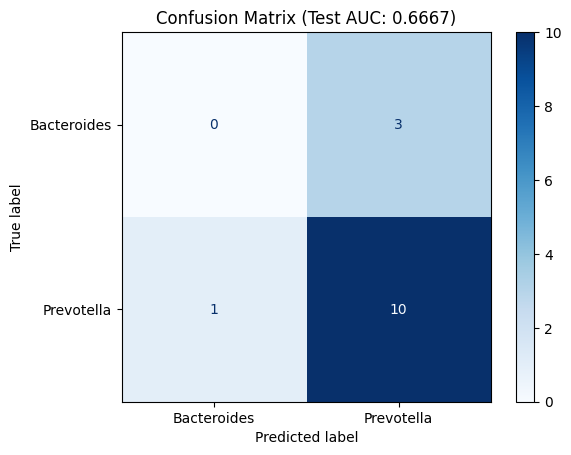

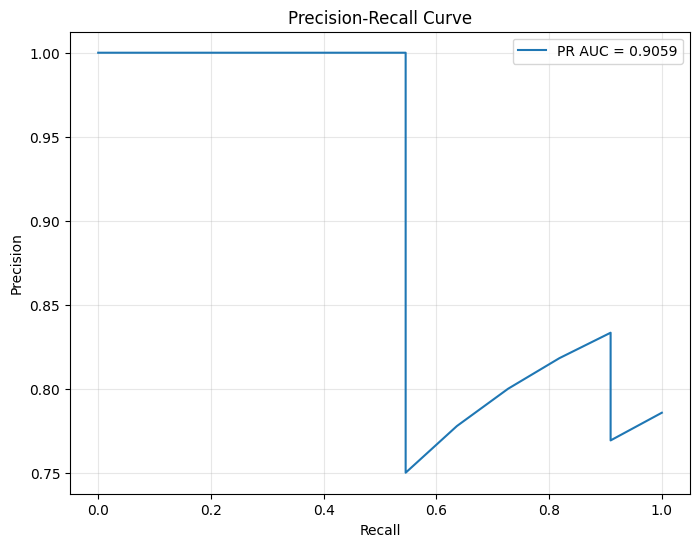

In [24]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, auc as pr_auc

# 1. Cross-validation with per-fold AUCs
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_aucs = []

for fold, (train_idx, test_idx) in enumerate(skf.split(X_scaled, y), 1):
    X_tr, X_te = X_scaled[train_idx], X_scaled[test_idx]
    y_tr, y_te = y.iloc[train_idx], y.iloc[test_idx]
    
    best_rf.fit(X_tr, y_tr)
    y_proba = best_rf.predict_proba(X_te)[:, 1]
    fold_auc = roc_auc_score(y_te, y_proba)
    cv_aucs.append(fold_auc)
    print(f"Fold {fold} AUC: {fold_auc:.4f}")

print(f"\nMean CV AUC: {np.mean(cv_aucs):.4f} ± {np.std(cv_aucs):.4f}")

# 2. Final train+test split evaluation
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

best_rf.fit(X_train, y_train)
y_pred = best_rf.predict(X_test)
y_proba = best_rf.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, y_proba)
print(f"\nFinal Test AUC: {test_auc:.4f}")

# 3. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Bacteroides", "Prevotella"])
disp.plot(cmap="Blues")
plt.title(f"Confusion Matrix (Test AUC: {test_auc:.4f})")
plt.show()

# 4. Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_proba)
pr_auc_score = pr_auc(recall, precision)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f"PR AUC = {pr_auc_score:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [27]:
# 1. Check class distribution
print("=== Class Distribution ===")
print(y.value_counts())
print(f"\nClass balance: {y.value_counts(normalize=True)}")
print(f"Total samples: {len(y)}")

# 2. Check for NaN values in X_scaled
print(f"\n=== Data Quality Check ===")
print(f"NaN values in X_scaled: {np.isnan(X_scaled).sum()}")
print(f"Inf values in X_scaled: {np.isinf(X_scaled).sum()}")

# Replace NaN/Inf with 0 or use imputation
X_scaled_clean = np.nan_to_num(X_scaled, nan=0.0, posinf=0.0, neginf=0.0)

# 3. Check train/test overfitting
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled_clean, y, test_size=0.2, stratify=y, random_state=42
)

best_rf.fit(X_train, y_train)

# Training set performance
y_train_proba = best_rf.predict_proba(X_train)[:, 1]
train_auc = roc_auc_score(y_train, y_train_proba)

# Test set performance
y_test_proba = best_rf.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, y_test_proba)

print(f"\n=== Overfitting Check ===")
print(f"Train AUC: {train_auc:.4f}")
print(f"Test AUC:  {test_auc:.4f}")
print(f"Gap: {train_auc - test_auc:.4f}")

if train_auc - test_auc > 0.1:
    print("⚠️ WARNING: Significant overfitting detected!")

# 4. Address class imbalance with SMOTE
from imblearn.over_sampling import SMOTE

print("\n=== Trying SMOTE for class balance ===")
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled_clean, y)

print(f"Original distribution: {y.value_counts().to_dict()}")
print(f"Resampled distribution: {pd.Series(y_resampled).value_counts().to_dict()}")

# 5. Retrain with balanced data
X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(
    X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42
)

rf_balanced = RandomForestClassifier(
    n_estimators=500,
    max_depth=8,
    random_state=42,
    min_samples_leaf=1,
    min_samples_split=2
)
rf_balanced.fit(X_train_sm, y_train_sm)

y_test_proba_sm = rf_balanced.predict_proba(X_test_sm)[:, 1]
test_auc_sm = roc_auc_score(y_test_sm, y_test_proba_sm)

print(f"\nBalanced Test AUC: {test_auc_sm:.4f}")

=== Class Distribution ===
1.0    52
0.0    16
Name: count, dtype: int64

Class balance: 1.0    0.764706
0.0    0.235294
Name: proportion, dtype: float64
Total samples: 68

=== Data Quality Check ===
NaN values in X_scaled: 33466
Inf values in X_scaled: 0

=== Overfitting Check ===
Train AUC: 1.0000
Test AUC:  0.6970
Gap: 0.3030
⚠️ WARNING: Significant overfitting detected!

=== Trying SMOTE for class balance ===
Original distribution: {1.0: 52, 0.0: 16}
Resampled distribution: {1.0: 52, 0.0: 52}

Balanced Test AUC: 1.0000


In [ ]:
# 1. Feature filtering to reduce overfitting
prevalence = (X > 0).sum(axis=0) / X.shape[0] * 100
X_filtered = X.loc[:, prevalence >= 30]  # Increase from 20% to 30%

# 2. Better log transformation (avoid NaNs)
X_log = np.log1p(X_filtered)  # log1p handles zeros better than log10(x + 1e-6)

# 3. Standardize
scaler = StandardScaler()
X_scaled_clean = scaler.fit_transform(X_log)

# 4. Handle any remaining NaN/Inf values
X_scaled_clean = np.nan_to_num(X_scaled_clean, nan=0.0, posinf=0.0, neginf=0.0)

print(f"Features after filtering: {X_scaled_clean.shape[1]}")
print(f"NaN check: {np.isnan(X_scaled_clean).sum()}")
print(f"Inf check: {np.isinf(X_scaled_clean).sum()}")

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled_clean, y, test_size=0.25, stratify=y, random_state=42
)

# Apply SMOTE only on training data
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

print(f"\nTraining set after SMOTE: {pd.Series(y_train_sm).value_counts().to_dict()}")
print(f"Test set (unchanged): {y_test.value_counts().to_dict()}")

# === TRAIN WITH REGULARIZATION ===
rf_final = RandomForestClassifier(
    n_estimators=300,
    max_depth=5,  # Reduce from 8 to prevent overfitting
    min_samples_split=10,  # Increase from 2
    min_samples_leaf=5,    # Increase from 1
    max_features='sqrt',   # Add feature subsampling
    class_weight='balanced',  # Also use class weights
    random_state=42
)

rf_final.fit(X_train_sm, y_train_sm)

# Evaluate
y_train_pred = rf_final.predict_proba(X_train_sm)[:, 1]
y_test_pred = rf_final.predict_proba(X_test)[:, 1]

train_auc = roc_auc_score(y_train_sm, y_train_pred)
test_auc = roc_auc_score(y_test, y_test_pred)

print(f"\n=== Final Results ===")
print(f"Train AUC: {train_auc:.4f}")
print(f"Test AUC:  {test_auc:.4f}")
print(f"Gap: {train_auc - test_auc:.4f}")

Features after filtering: 1151
NaN check: 0
Inf check: 0

Training set after SMOTE: {0.0: 39, 1.0: 39}
Test set (unchanged): {1.0: 13, 0.0: 4}

=== Final Results ===
Train AUC: 1.0000
Test AUC:  0.8654
Gap: 0.1346



=== Final Results ===
Train AUC: 0.9842
Test AUC:  0.8462
Gap: 0.1381


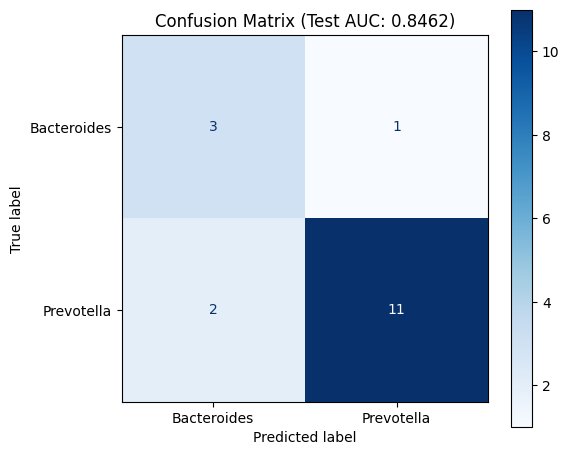

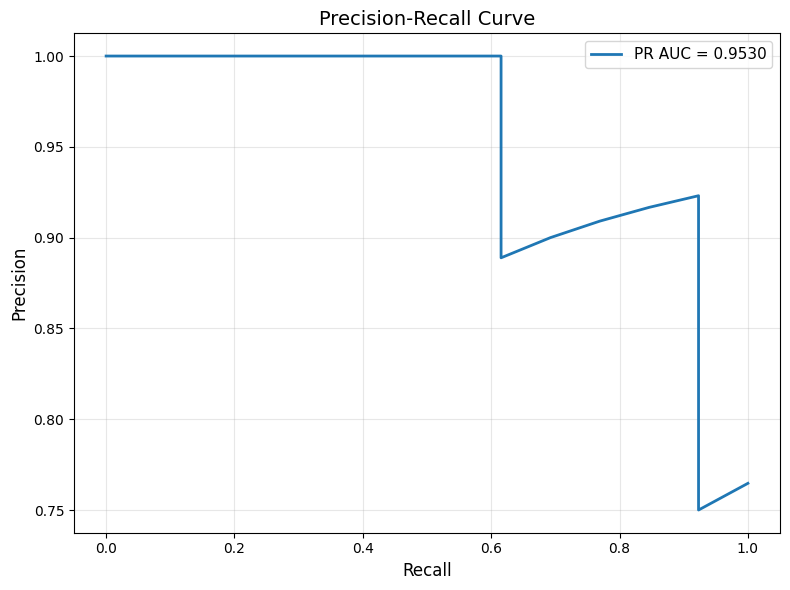


=== Model Summary ===
Test samples: 17 (Bacteroides: 4, Prevotella: 13)
Features used: 1151
PR AUC: 0.9530


In [35]:
# === TRAIN WITH REGULARIZATION ===
rf_final = RandomForestClassifier(
    n_estimators=200,  # Reduce trees
    max_depth=2,       # Even shallower trees
    min_samples_split=25,
    min_samples_leaf=15,
    max_features='sqrt',
    class_weight='balanced',
    random_state=42
)

rf_final.fit(X_train_sm, y_train_sm)

# Evaluate
y_train_pred = rf_final.predict_proba(X_train_sm)[:, 1]
y_test_pred = rf_final.predict_proba(X_test)[:, 1]

train_auc = roc_auc_score(y_train_sm, y_train_pred)
test_auc = roc_auc_score(y_test, y_test_pred)

print(f"\n=== Final Results ===")
print(f"Train AUC: {train_auc:.4f}")
print(f"Test AUC:  {test_auc:.4f}")
print(f"Gap: {train_auc - test_auc:.4f}")

# Add confusion matrix and PR curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve,auc

y_test_pred_class = rf_final.predict(X_test)

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred_class)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Bacteroides", "Prevotella"])
fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(cmap="Blues", ax=ax)
plt.title(f"Confusion Matrix (Test AUC: {test_auc:.4f})")
plt.tight_layout()
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_test_pred)
pr_auc_score = auc(recall, precision)  # Remove int() - pass arrays directly

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, linewidth=2, label=f"PR AUC = {pr_auc_score:.4f}")
plt.xlabel("Recall", fontsize=12)
plt.ylabel("Precision", fontsize=12)
plt.title("Precision-Recall Curve", fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n=== Model Summary ===")
print(f"Test samples: {len(y_test)} (Bacteroides: {(y_test==0).sum()}, Prevotella: {(y_test==1).sum()})")
print(f"Features used: {X_scaled_clean.shape[1]}")
print(f"PR AUC: {pr_auc_score:.4f}")

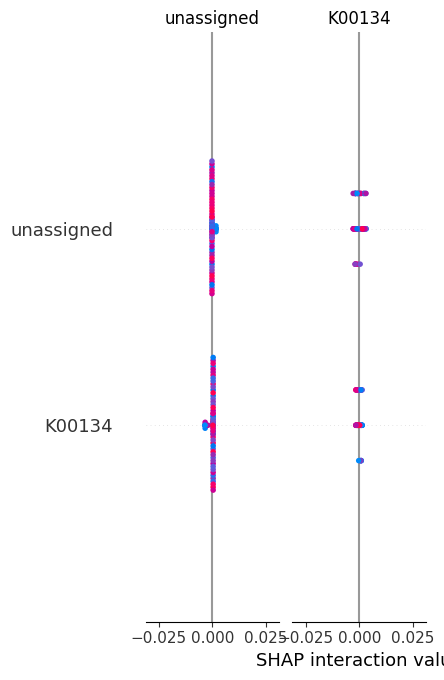

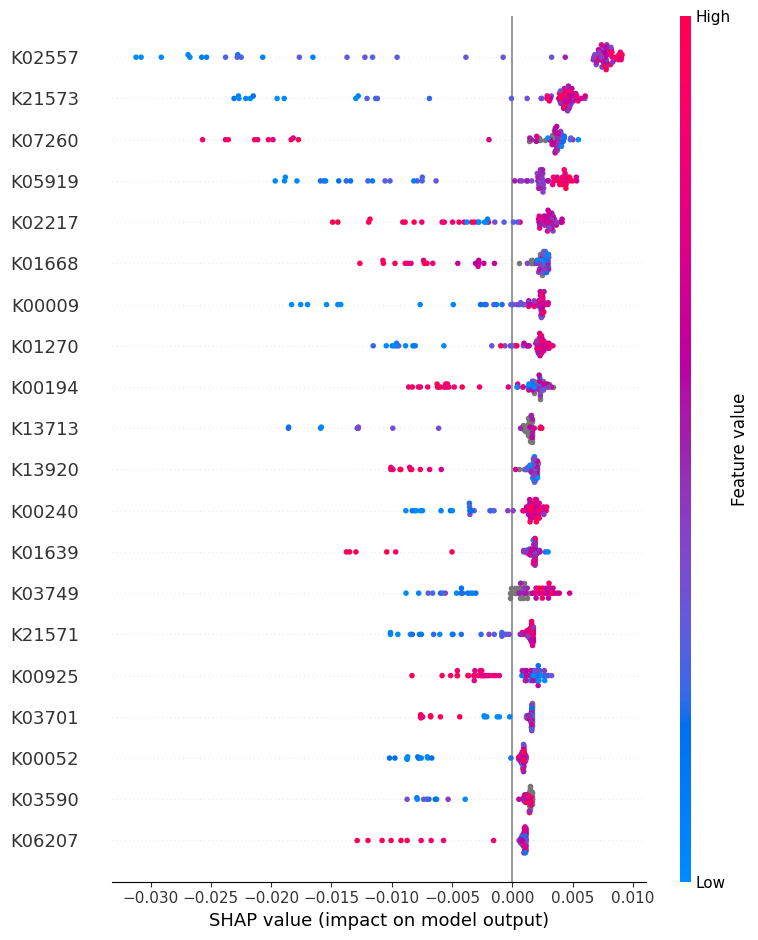

In [36]:
import shap

best_rf = gs.best_estimator_
explainer = shap.TreeExplainer(best_rf)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

# Get SHAP values
shap_values = explainer(X_scaled_df)

# Use the new plotting API (works with SHAP v0.40+)
shap.summary_plot(shap_values, X_scaled_df)

# Or for just the positive class:
shap.summary_plot(shap_values[:, :, 1], X_scaled_df)

High abundance of K05919 and K0217 pushes predictions toward Bacteroides‑dominant enterotypes, while low abundance pulls toward Prevotella‑dominant.

=== SHAP Summary Plot ===


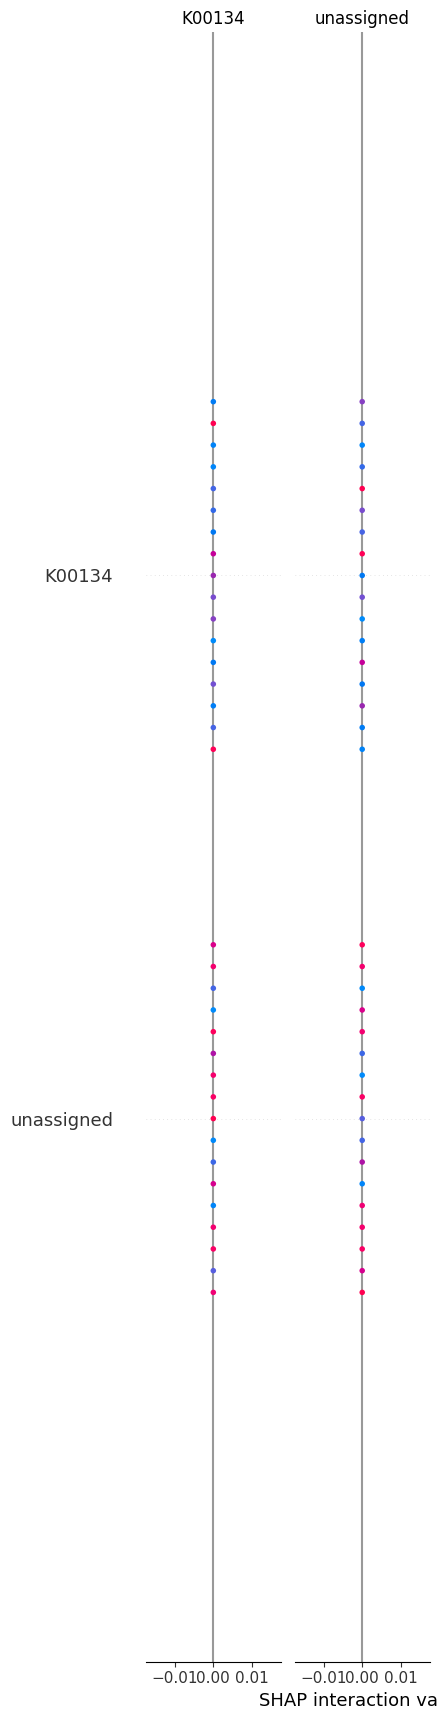


=== SHAP Summary Plot for Prevotella-dominant (Class 1) ===


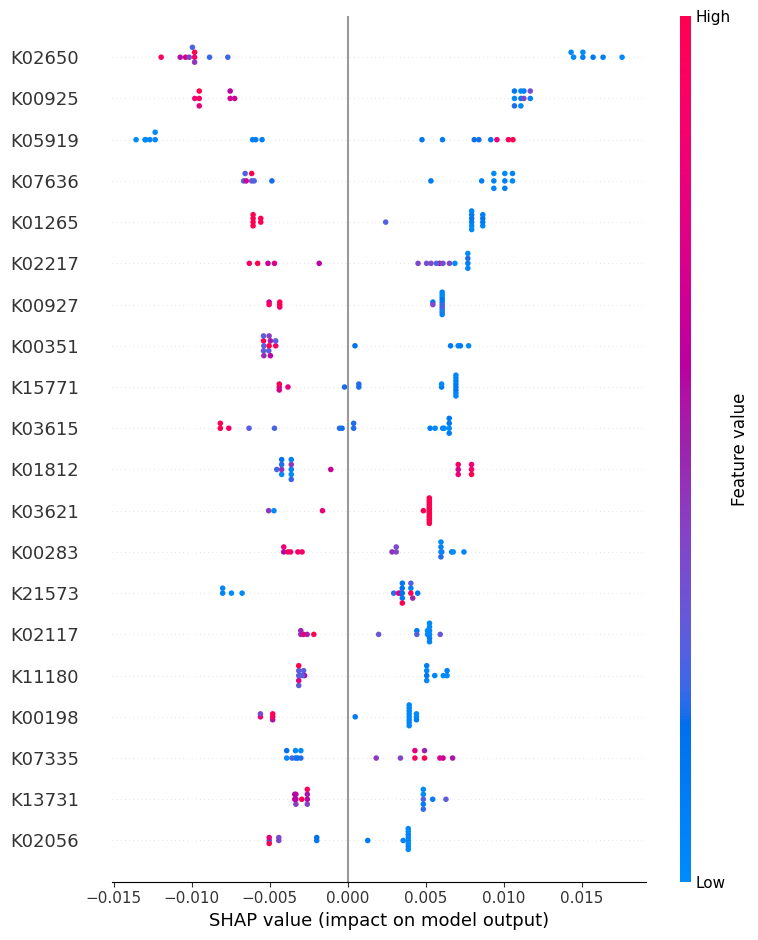


=== SHAP Feature Importance ===


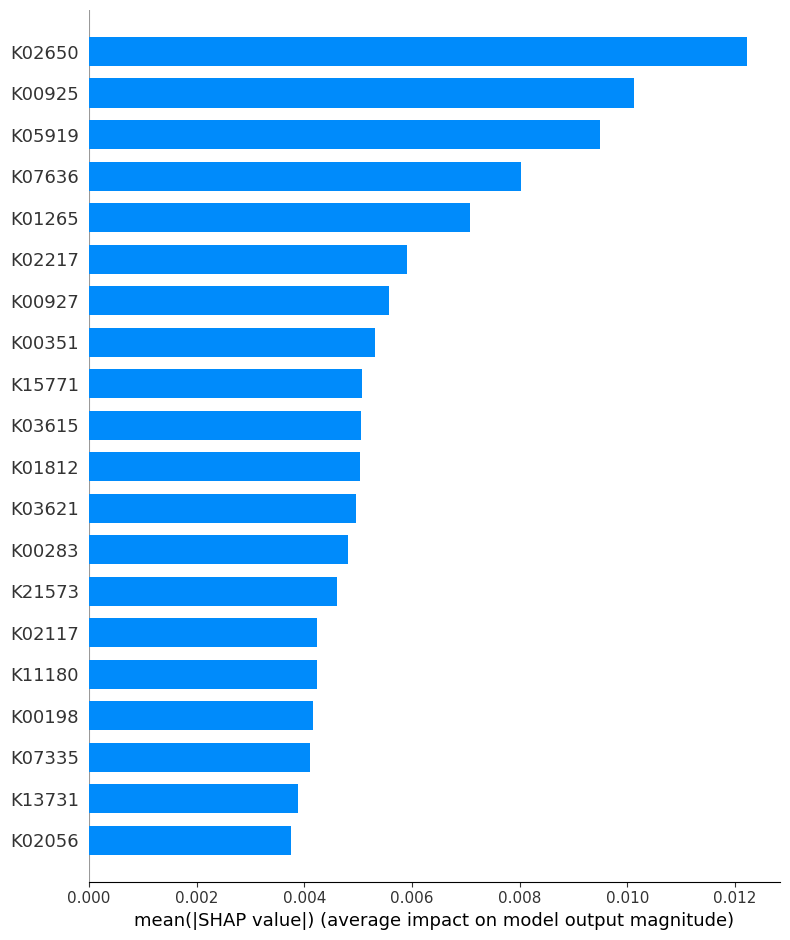


=== Top 10 Most Important Features ===
1. K02650: 0.0122
2. K00925: 0.0101
3. K05919: 0.0095
4. K07636: 0.0080
5. K01265: 0.0071
6. K02217: 0.0059
7. K00927: 0.0056
8. K00351: 0.0053
9. K15771: 0.0051
10. K03615: 0.0050


In [ ]:
import shap

explainer = shap.TreeExplainer(rf_final)

feature_names = X_filtered.columns.tolist()

X_test_df = pd.DataFrame(X_test, columns=feature_names)

# Calculate SHAP values
shap_values = explainer(X_test_df)

shap.summary_plot(shap_values, X_test_df, max_display=20)

# Summary plot for Prevotella class (class 1)
print("\n=== SHAP Summary Plot for Prevotella-dominant (Class 1) ===")
shap.summary_plot(shap_values[:, :, 1], X_test_df, max_display=20)

# Bar plot showing mean absolute SHAP values (feature importance)
print("\n=== SHAP Feature Importance ===")
shap.summary_plot(shap_values[:, :, 1], X_test_df, plot_type="bar", max_display=20)

# Get top 10 most important features
shap_importance = np.abs(shap_values.values[:, :, 1]).mean(axis=0)
top_features_idx = np.argsort(shap_importance)[-10:][::-1]
top_features = [feature_names[i] for i in top_features_idx]

print("\n=== Top 10 Most Important Features ===")
for i, feature in enumerate(top_features, 1):
    print(f"{i}. {feature}: {shap_importance[top_features_idx[i-1]]:.4f}")